
# 6-year run: variability in float observations
# compare variability captured by daily vs. 10-daily observations
# metric for "variability": seasonal amplitude (also look at the annual mean)
# plot maps + vertical profiles within biomes in separate script
# Fig. 6 of GMD paper


In [1]:

import sys
sys.path.append('/global/homes/c/cnissen/scripts/seawater-3.3.4/seawater/')
import os
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
#from seawater import dist
#import seawater as sw
import matplotlib.path as mpath
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from numba import njit
import time
from statsmodels.stats.weightstats import DescrStatsW
from tqdm import tqdm
from math import sin, cos, sqrt, atan2, radians


In [2]:
#-----
# saving plots
#-----

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/vertical_profiles_biomes/6year_run/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    

In [3]:
#---
# read mesh info
#---
rad_to_deg = 180.0/np.pi

path_mesh = '/global/cfs/cdirs/m4003/maltrud/'
meshID = 'EC30to60E2r2'
meshfile = xr. open_dataset(path_mesh+'ocean.'+meshID+'.210210.nc')
#print(meshfile)

lon  = meshfile['lonCell'].values*rad_to_deg
lat  = meshfile['latCell'].values*rad_to_deg
topo = meshfile['bottomDepth'].values
area = meshfile['areaCell'].values
zlevs            = meshfile['refBottomDepth'].values
layerThickness   = meshfile['layerThickness'].values
restingThickness = meshfile['restingThickness'].values

print(len(lon),'nodes in mesh')
print(topo.shape)
print(area.shape)
print('Min/Max lon:',np.min(lon),np.max(lon))
print('Min/Max lat:',np.min(lat),np.max(lat))
print('layerThickness.shape:',layerThickness.shape)
print('restingThickness.shape:',restingThickness.shape)

meshfile.close()

# get volume
area3D = np.tile(area,[len(zlevs),1])
print('area3D.shape:',area3D.shape)

volume = np.multiply(area3D,restingThickness.transpose())
print('volume.shape:',volume.shape)


236853 nodes in mesh
(236853,)
(236853,)
Min/Max lon: 0.0007300572350528742 359.997672445938
Min/Max lat: -78.53259417674468 89.94461290099375
layerThickness.shape: (1, 236853, 60)
restingThickness.shape: (236853, 60)
area3D.shape: (60, 236853)
volume.shape: (60, 236853)


In [4]:
#----
# load daily float output from E3SM: oxygen, nitrate
#----
# NOTE: the reduction to "deep" floats is not 100% exact.
#  -> when running this over different years, a different number of floats is identified as "shallow" floats
#  -> for now, I kick out those that are "shallow" on day 1 of year 1
# How to treat this later?

path = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'
year_list = ['0057']#'0055',,'0056','0057','0058','0059','0060']

# kick out floats in shallow regions (these are not advected I think)
ind = np.where(zlevs<=2200)[0]

for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    file1 = 'floats.year'+year_list[yy]+'.nc'   
    data = xr. open_dataset(path+file1)

    lon_1   = data['particleColumnLon'].values*rad_to_deg 
    lat_1   = data['particleColumnLat'].values*rad_to_deg 
    oxy_1   = data['particleColumnO2'].values #[:,0,:]
    no3_1   = data['particleColumnNO3'].values
    temp_1  = data['particleColumnTemperature'].values
    #print('lat_all',lat_all.shape)

    # set missing values to NaN (deep ocean layers) 
    lat_1[oxy_1==-1]=np.nan
    lon_1[oxy_1==-1]=np.nan
    no3_1[oxy_1==-1]=np.nan 
    temp_1[oxy_1==-1]=np.nan 
    oxy_1[oxy_1==-1]=np.nan 
    no3_1[oxy_1==0]=np.nan 
    temp_1[oxy_1==0]=np.nan 
    oxy_1[oxy_1==0]=np.nan 
    
    print('Reduce to floats in the deep ocean')
    if yy==0: # only load the first time, re-use ind_deep
        aux = np.sum(np.isnan(oxy_1[0,ind,:]),axis=0) # check if any of the depth levels shallower than XXm is NaN
        ind_deep = np.where(aux==0)[0] # if it is, aux is >0; only keep those that are 0
  #  #print('Floats in the deep ocean:',ind_deep.shape)
    lon_1   = lon_1[:,:,ind_deep]
    lat_1   = lat_1[:,:,ind_deep]
    no3_1   = no3_1[:,:,ind_deep]
    temp_1  = temp_1[:,:,ind_deep]
    oxy_1   = oxy_1[:,:,ind_deep]
    
    if yy==0: # first time
        lat_all_E3SM = lat_1[:,0,:]
        lon_all_E3SM = lon_1[:,0,:]
        no3_all_E3SM   = no3_1
        temp_all_E3SM  = temp_1
        oxy_all_E3SM   = oxy_1
    else:
        lat_all_E3SM = np.concatenate((lat_all_E3SM,lat_1[:,0,:]))
        lon_all_E3SM = np.concatenate((lon_all_E3SM,lon_1[:,0,:]))
        no3_all_E3SM = np.concatenate((no3_all_E3SM,no3_1))
        temp_all_E3SM= np.concatenate((temp_all_E3SM,temp_1))
        oxy_all_E3SM = np.concatenate((oxy_all_E3SM,oxy_1))
        
    del no3_1,oxy_1,temp_1
    print(no3_all_E3SM.shape)
    
print ('done')
    

Load year 0057
Reduce to floats in the deep ocean
(364, 60, 8956)
done


In [5]:
#---
# load pH from floats
#---

# kick out floats in shallow regions (these are not advected I think)
ind = np.where(zlevs<=2200)[0]

path = '/global/cfs/cdirs/m4003/cnissen/floats/6year/'
for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    file1 = 'pH_floats_6year_'+year_list[yy]+'.nc'   
    data = xr. open_dataset(path+file1)

    pH_1   = data['pH'].values 

    ## set missing values to NaN (deep ocean layers) 
    pH_1[pH_1>99]=np.nan # some locations are 1e20 -> I think that stems from carbonate chemistry routines
    pH_1[pH_1==0]=np.nan
    
    print('Reduce to floats in the deep ocean')
    #if yy==0: # only load the first time, re-use ind_deep
    #    aux = np.sum(np.isnan(pH_1[0,ind,:]),axis=0) # check if any of the depth levels shallower than XXm is NaN
    #    ind_deep = np.where(aux==0)[0] # if it is, aux is >0; only keep those that are 0
    pH_1   = pH_1[:,:,ind_deep]
    
    if yy==0: # first time
        pH_all_E3SM   = pH_1
    else:
        pH_all_E3SM = np.concatenate((pH_all_E3SM,pH_1))
        
    del pH_1
    print(pH_all_E3SM.shape,np.nanmin(pH_all_E3SM),np.nanmax(pH_all_E3SM))
    

Load year 0057
Reduce to floats in the deep ocean
(364, 60, 8956) 7.052453 8.255184


In [6]:
#---
# load file in which profiles are colocated with biomes
#---

path_biome = '/global/cfs/cdirs/m4003/cnissen/6year_run/'

for yy in range(0,len(year_list)):
    print('Load year '+year_list[yy])
    file_biome = 'Float_positions_colocated_with_biomes_year'+year_list[yy]+'_v2.nc'

    ff = xr. open_dataset(path_biome+file_biome)
    closest_node= ff['closest_node'].values.squeeze()
    biome       = ff['biome_index'].values.squeeze()
    ff.close()
    
    if yy==0: # first time
        closest_node_all   = closest_node
    else:
        closest_node_all = np.concatenate((closest_node_all,closest_node))
    if yy==0: # first time
        biome_all   = biome
    else:
        biome_all = np.concatenate((biome_all,biome))
    del closest_node,biome
        
#closest_node_10 = closest_node_all[::10,:][:,ind_deep] # do this further down -> select the correct strting indices
closest_node_all = closest_node_all[:,ind_deep]
biome_all        = biome_all[:,ind_deep]

print('Min/Max index closest_node_all:',\
      closest_node_all.shape,np.min(closest_node_all),np.max(closest_node_all))
print('Min/Max index biome_all:',\
      biome_all.shape,np.min(biome_all),np.max(biome_all))

print ('done')


Load year 0057
Min/Max index closest_node_all: (364, 8956) 1.0 236846.0
Min/Max index biome_all: (364, 8956) 0.0 27.0
done


In [7]:
#---
# reduce to 10-daily
# test: don't sample all floats on day 1, 11, 21 etc (instead, sample some at day 5, 15, 25 etc)
#---

# get 10560 random numbers between 0-9
ind_start = np.random.choice(np.arange(0,10), size=no3_all_E3SM.shape[2], replace=True)
#print(ind_start.shape)
#print(ind_start)

no3_all_E3SM_10  = np.nan*np.ones([int(np.ceil(no3_all_E3SM.shape[0]/10)),no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]]) # 37 x 60 x 10560
oxy_all_E3SM_10  = np.nan*np.ones([int(np.ceil(oxy_all_E3SM.shape[0]/10)),oxy_all_E3SM.shape[1],oxy_all_E3SM.shape[2]])
pH_all_E3SM_10   = np.nan*np.ones([int(np.ceil(pH_all_E3SM.shape[0]/10)),pH_all_E3SM.shape[1],pH_all_E3SM.shape[2]])
temp_all_E3SM_10 = np.nan*np.ones([int(np.ceil(temp_all_E3SM.shape[0]/10)),temp_all_E3SM.shape[1],temp_all_E3SM.shape[2]])
lon_all_E3SM_10  = np.nan*np.ones([int(np.ceil(pH_all_E3SM.shape[0]/10)),pH_all_E3SM.shape[2]])
lat_all_E3SM_10  = np.nan*np.ones([int(np.ceil(pH_all_E3SM.shape[0]/10)),pH_all_E3SM.shape[2]])
closest_node_all_10 = np.nan*np.ones([int(np.ceil(closest_node_all.shape[0]/10)),closest_node_all.shape[1]])
biome_all_10        = np.nan*np.ones([int(np.ceil(biome_all.shape[0]/10)),biome_all.shape[1]])
for ii in range(0,len(ind_start)):
    try: # depending on the starting index, the resulting field has 36 or 37 entries
        no3_all_E3SM_10[:,:,ii]  = no3_all_E3SM[ind_start[ii]::10,:,ii]
    except:
        no3_all_E3SM_10[1:,:,ii] = no3_all_E3SM[ind_start[ii]::10,:,ii]
    try:
        oxy_all_E3SM_10[:,:,ii]  = oxy_all_E3SM[ind_start[ii]::10,:,ii]
    except:
        oxy_all_E3SM_10[1:,:,ii] = oxy_all_E3SM[ind_start[ii]::10,:,ii]
    try:
        temp_all_E3SM_10[:,:,ii]  = temp_all_E3SM[ind_start[ii]::10,:,ii]
    except:
        temp_all_E3SM_10[1:,:,ii] = temp_all_E3SM[ind_start[ii]::10,:,ii]
    try:
        pH_all_E3SM_10[:,:,ii]   = pH_all_E3SM[ind_start[ii]::10,:,ii]
    except:
        pH_all_E3SM_10[1:,:,ii]  = pH_all_E3SM[ind_start[ii]::10,:,ii]
    # lat/lon (2D)
    try:
        lat_all_E3SM_10[:,ii]   = lat_all_E3SM[ind_start[ii]::10,ii]
    except:
        lat_all_E3SM_10[1:,ii]  = lat_all_E3SM[ind_start[ii]::10,ii]
    try:
        lon_all_E3SM_10[:,ii]   = lon_all_E3SM[ind_start[ii]::10,ii]
    except:
        lon_all_E3SM_10[1:,ii]  = lon_all_E3SM[ind_start[ii]::10,ii]
    # biome colocation
    try:
        closest_node_all_10[:,ii]   = closest_node_all[ind_start[ii]::10,ii]
    except:
        closest_node_all_10[1:,ii]  = closest_node_all[ind_start[ii]::10,ii]
    try:
        biome_all_10[:,ii]   = biome_all[ind_start[ii]::10,ii]
    except:
        biome_all_10[1:,ii]  = biome_all[ind_start[ii]::10,ii]

print(no3_all_E3SM_10.shape)
print(no3_all_E3SM.shape)


(37, 60, 8956)
(364, 60, 8956)


In [8]:
#---
# define depth arrays
#---

zlevs0 = np.concatenate(([0],zlevs))
#print(zlevs0)
dz = np.diff(zlevs0)
print (dz)

dz_3D = np.transpose(np.tile(dz,[no3_all_E3SM_10.shape[0],no3_all_E3SM_10.shape[2],1]),[0,2,1])
print(dz_3D.shape)


[ 10.          10.          10.          10.          10.
  10.          10.          10.          10.          10.
  10.          10.          10.          10.          10.
  10.          10.19679688  10.56449219  11.05992187  11.67808594
  12.42410156  13.30972656  14.35136719  15.57128906  16.99675781
  18.66214844  20.60898437  22.88855469  25.56242187  28.70578125
  32.40835937  36.77773438  41.9403125   48.04226563  55.2475
  63.73195313  73.66945312  85.20898438  98.43648437 113.32476563
 129.67195312 147.05351563 164.80695312 182.09148438 198.02226562
 211.85960938 223.16507812 231.86492188 238.19445313 242.57242187
 245.46757813 247.31054688 248.44320312 249.11992187 249.51257813
 249.73617187 249.85945313 249.92679687 249.96257813 249.98054687]
(37, 60, 8956)


(37, 60, 8956)
(37, 8956)
['0057']
tropics_21S_21N
Number of floats in subregion: 5755
Max ratio: 1.6228226865897342 1854
(37,) (364,)


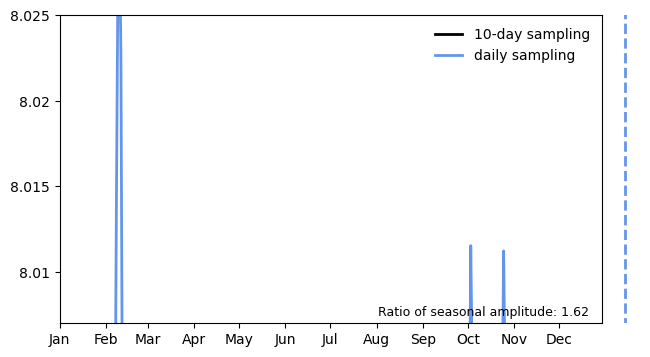

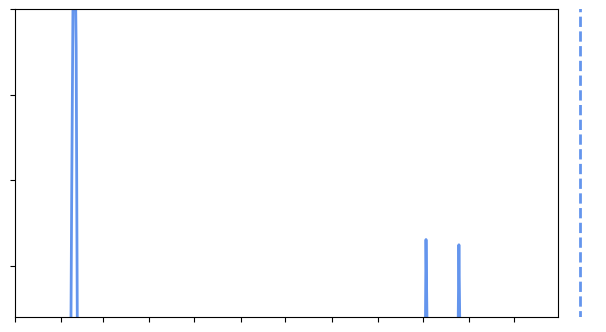

In [9]:
#---
# make example plot of what I am comparing
#---
# find a good annual trajectory in the tropics (eddy-permitting!) where I can show the difference in variability
from matplotlib.lines import Line2D

print(no3_all_E3SM_10.shape)
print(lat_all_E3SM_10.shape)
print(year_list)

#latlim1 = 60 # southern limit
#latlim2 = 90  # northern limit

#latlim1 = 21 # southern limit
#latlim2 = 60  # northern limit

latlim1 = -21 # southern limit
latlim2 = 21  # northern limit

#latlim1 = -60 # southern limit
#latlim2 = -21  # northern limit

#latlim1 = -90 # southern limit
#latlim2 = -60  # northern limit

region_name = 'tropics_21S_21N'
print(region_name)

# check if float is in eddy-permitting region the whole year (between 21°S and 21°N)
is_in_tropics = np.zeros(lat_all_E3SM_10.shape[1])
for ff in range(0,lat_all_E3SM_10.shape[1]):
    aux1 = lat_all_E3SM_10[:,ff]
    ind=np.where(~np.isnan(aux1))[0]
    aux1 = aux1[ind]
    if all(i >=latlim1 for i in aux1): # if all latitudes are north of 21°S
        if all(i <=latlim2 for i in aux1): # if all latitudes are south of 21°N
            is_in_tropics[ff]=1
    del aux1,ind
    
ind_tropics = is_in_tropics==1

print('Number of floats in subregion:',np.sum(1*ind_tropics))

all_in_tropics = np.where(is_in_tropics==1)[0]
#print(all_in_tropics)

vari = 'pH'

if vari in ['no3']:
    aux1 = no3_all_E3SM_10[:,0,all_in_tropics]
    aux2 = no3_all_E3SM[:,0,all_in_tropics]
    ylim1,ylim2 = 0,2.5
    yticks = [0,0.5,1,1.5,2,2.5] #[7,7.5,8]
elif vari in ['temp']:
    aux1 = temp_all_E3SM_10[:,0,all_in_tropics]
    aux2 = temp_all_E3SM[:,0,all_in_tropics]
    ylim1,ylim2 = 26.2,29.5
    yticks = [27,28,29] #[7,7.5,8]
elif vari in ['pH']:
    aux1 = pH_all_E3SM_10[:,0,all_in_tropics]
    aux2 = pH_all_E3SM[:,0,all_in_tropics]
    ylim1,ylim2 = 8.007,8.025 #7.951,7.996
    yticks = [8.01,8.015,8.02,8.025]#[7.96,7.97,7.98,7.99]

aux_ratio = np.zeros(len(all_in_tropics))
for ff in range(0,aux1.shape[1]):
    aux_ratio[ff] = (np.max(aux2[:,ff])-np.min(aux2[:,ff]))/(np.max(aux1[:,ff])-np.min(aux1[:,ff]))
print('Max ratio:',np.nanmax(aux_ratio),np.nanargmax(aux_ratio))

ind_plot = np.nanargmax(aux_ratio) #15
data_plot1 = aux1[:,ind_plot]
data_plot2 = aux2[:,ind_plot]
print(data_plot1.shape,data_plot2.shape)

days_in_months = np.cumsum([0,31,28,31,30,31,30,31,31,30,31,30,31]) # python indexing of day in calendar year at the end of each month
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

save_plots = True
plot_eps = True

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(7.5,4),gridspec_kw={'width_ratios': [1,0.05]})
ax1.plot(np.arange(2,364,10),data_plot1,color='black',linewidth=2,label='10-day sampling')
ax1.plot(np.arange(0,364,1),data_plot2,color='cornflowerblue',linewidth=2,label='daily sampling')
ax1.set_xticks(days_in_months[:-1])
ax1.set_xticklabels(months)
ax1.set_xlim((0,363))
ax1.set_ylim((ylim1,ylim2))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks)
ax1.legend(frameon=False)
ax1.annotate('Ratio of seasonal amplitude: '+str(np.round(100*np.nanmax(aux_ratio))/100),xy=(0.975,0.025),\
                    xycoords='axes fraction',fontsize=9,ha='right',color='k') #fontweight='bold',

ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.vlines(0,np.min(data_plot1),np.max(data_plot1),color='black',linestyle='--',linewidth=2)
ax2.vlines(0.2,np.min(data_plot2),np.max(data_plot2),color='cornflowerblue',linestyle='--',linewidth=2)
ax2.set_xlim((0,0.5))
ax2.set_ylim((ylim1,ylim2))
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.subplots_adjust(wspace=0.04, hspace=0)

if save_plots:
    dpicnt = 200
    filename = 'Example_time_series_'+vari+'_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'_year_'+year_list[0]+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()

if plot_eps: 
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(7.5,4),gridspec_kw={'width_ratios': [1,0.05]})
    ax1.plot(np.arange(2,364,10),data_plot1,color='black',linewidth=2)
    ax1.plot(np.arange(0,364,1),data_plot2,color='cornflowerblue',linewidth=2)
    ax1.set_xticks(days_in_months[:-1])
    ax1.set_xticklabels([])
    ax1.set_xlim((0,363))
    ax1.set_ylim((ylim1,ylim2))
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([])

    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.vlines(0,np.min(data_plot1),np.max(data_plot1),color='black',linestyle='--',linewidth=2)
    ax2.vlines(0.2,np.min(data_plot2),np.max(data_plot2),color='cornflowerblue',linestyle='--',linewidth=2)
    ax2.set_xlim((0,0.5))
    ax2.set_ylim((ylim1,ylim2))
    ax2.set_xticks([])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    plt.subplots_adjust(wspace=0.04, hspace=0)

    if save_plots:
        dpicnt = 200
        filename = 'Example_time_series_'+vari+'_seasonal_amplitude_daily_vs_10day_sampling_'+region_name+'_year_'+year_list[0]+'.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')#,transparent=True)

    plt.show()



In [10]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/E3SM_floats/vertical_profiles_biomes/6year_run/


In [11]:
#---
# get difference in seasonal amplitude along the tracks of each float 
#---

print(no3_all_E3SM_10.shape)
print(no3_all_E3SM.shape)

# 55,72 was inf

no3_ampl_ratio  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
oxy_ampl_ratio  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
pH_ampl_ratio   = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
temp_ampl_ratio = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
# range daily sampling
no3_ampl_daily  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
oxy_ampl_daily  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
pH_ampl_daily   = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
temp_ampl_daily = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
# range 10-day sampling
no3_ampl_10day  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
oxy_ampl_10day  = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
pH_ampl_10day   = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
temp_ampl_10day = np.zeros([no3_all_E3SM.shape[1],no3_all_E3SM.shape[2]])
for dd in tqdm(range(0,no3_all_E3SM.shape[1])): # depths
    for ff in range(0,no3_all_E3SM.shape[2]): # floats
        #----
        # nitrate
        #----
        aux1 = no3_all_E3SM[:,dd,ff]
        aux1 = np.ma.masked_where(aux1==0,aux1)
        aux2 = no3_all_E3SM_10[:,dd,ff]
        aux2 = np.ma.masked_where(aux2==0,aux2)
        #print(aux1) # time
        #print('NO3 aux1:',np.nanmin(aux1),np.nanmax(aux1))
        #print('NO3 aux2:',np.nanmin(aux2),np.nanmax(aux2))
        if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
            no3_ampl_daily[dd,ff] = np.nanmax(aux1)-np.nanmin(aux1)
            no3_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
            no3_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
        del aux1,aux2
        #----
        # oxygen
        #----
        aux1 = oxy_all_E3SM[:,dd,ff]
        aux1 = np.ma.masked_where(aux1==0,aux1)
        aux2 = oxy_all_E3SM_10[:,dd,ff]
        aux2 = np.ma.masked_where(aux2==0,aux2)
        #print('Oxy aux1:',np.nanmin(aux1),np.nanmax(aux1))
        #print('Oxy aux2:',np.nanmin(aux2),np.nanmax(aux2))
        if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
            oxy_ampl_daily[dd,ff] = np.nanmax(aux1)-np.nanmin(aux1)
            oxy_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
            oxy_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
        del aux1,aux2
        #----
        # temperature
        #----
        aux1 = temp_all_E3SM[:,dd,ff]
        aux1 = np.ma.masked_where(aux1==0,aux1)
        aux2 = temp_all_E3SM_10[:,dd,ff]
        aux2 = np.ma.masked_where(aux2==0,aux2)
        #print('Oxy aux1:',np.nanmin(aux1),np.nanmax(aux1))
        #print('Oxy aux2:',np.nanmin(aux2),np.nanmax(aux2))
        if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
            temp_ampl_daily[dd,ff] = np.nanmax(aux1)-np.nanmin(aux1)
            temp_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
            temp_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
        del aux1,aux2
        #----
        # pH
        #----
        aux1 = pH_all_E3SM[:,dd,ff]
        aux1 = np.ma.masked_where(aux1==0,aux1)
        aux2 = pH_all_E3SM_10[:,dd,ff]
        aux2 = np.ma.masked_where(aux2==0,aux2)
        #print('pH aux1:',np.nanmin(aux1),np.nanmax(aux1))
        #print('pH aux2:',np.nanmin(aux2),np.nanmax(aux2))
        if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
            pH_ampl_daily[dd,ff] = np.nanmax(aux1)-np.nanmin(aux1)
            pH_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
            pH_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
        del aux1,aux2
        
no3_ampl_ratio  = np.ma.masked_where(no3_ampl_ratio==0,no3_ampl_ratio)
oxy_ampl_ratio  = np.ma.masked_where(oxy_ampl_ratio==0,oxy_ampl_ratio)
temp_ampl_ratio = np.ma.masked_where(temp_ampl_ratio==0,temp_ampl_ratio)
pH_ampl_ratio   = np.ma.masked_where(pH_ampl_ratio==0,pH_ampl_ratio)

no3_ampl_daily  = np.ma.masked_where(no3_ampl_daily==0,no3_ampl_daily)
oxy_ampl_daily  = np.ma.masked_where(oxy_ampl_daily==0,oxy_ampl_daily)
temp_ampl_daily = np.ma.masked_where(temp_ampl_daily==0,temp_ampl_daily)
pH_ampl_daily   = np.ma.masked_where(pH_ampl_daily==0,pH_ampl_daily)

no3_ampl_10day  = np.ma.masked_where(no3_ampl_10day==0,no3_ampl_10day)
oxy_ampl_10day  = np.ma.masked_where(oxy_ampl_10day==0,oxy_ampl_10day)
temp_ampl_10day = np.ma.masked_where(temp_ampl_10day==0,temp_ampl_10day)
pH_ampl_10day   = np.ma.masked_where(pH_ampl_10day==0,pH_ampl_10day)


(37, 60, 8956)
(364, 60, 8956)


 73%|███████▎  | 44/60 [18:46<06:38, 24.90s/it]/tmp/ipykernel_65581/1822373110.py:36: RuntimeWarning: All-NaN axis encountered
  if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
/tmp/ipykernel_65581/1822373110.py:38: RuntimeWarning: All-NaN axis encountered
  no3_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
/tmp/ipykernel_65581/1822373110.py:39: RuntimeWarning: All-NaN axis encountered
  no3_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
/tmp/ipykernel_65581/1822373110.py:50: RuntimeWarning: All-NaN axis encountered
  if (np.nanmax(aux2)-np.nanmin(aux2))!=0:
/tmp/ipykernel_65581/1822373110.py:52: RuntimeWarning: All-NaN axis encountered
  oxy_ampl_10day[dd,ff] = np.nanmax(aux2)-np.nanmin(aux2)
/tmp/ipykernel_65581/1822373110.py:53: RuntimeWarning: All-NaN axis encountered
  oxy_ampl_ratio[dd,ff] = (np.nanmax(aux1)-np.nanmin(aux1))/(np.nanmax(aux2)-np.nanmin(aux2))
/tmp/ipykernel_65581/1822373110.py:64: RuntimeWarning: All-NaN axis encountered
  i

In [12]:
#----
# avg all floats in eddy-permitting area
#----

print(no3_ampl_ratio.shape)

# check if float is in eddy-permitting region the whole year (between 21°S and 21°N)
is_in_tropics = np.zeros(lat_all_E3SM_10.shape[1])
for ff in range(0,lat_all_E3SM_10.shape[1]):
    aux1 = lat_all_E3SM_10[:,ff]
    ind=np.where(~np.isnan(aux1))[0]
    aux1 = aux1[ind]
    if all(i >=-21 for i in aux1): # if all latitudes are north of 21°S
        if all(i <=21 for i in aux1): # if all latitudes are south of 21°N
            is_in_tropics[ff]=1
    del aux1,ind
    
ind_tropics = is_in_tropics==1

# mean
no3_ampl_ratio_tropics  = np.zeros([no3_ampl_ratio.shape[0]])
oxy_ampl_ratio_tropics  = np.zeros([oxy_ampl_ratio.shape[0]])
pH_ampl_ratio_tropics   = np.zeros([pH_ampl_ratio.shape[0]])
temp_ampl_ratio_tropics = np.zeros([temp_ampl_ratio.shape[0]])
# std
no3_ampl_ratio_tropics_std  = np.zeros([no3_ampl_ratio.shape[0]])
oxy_ampl_ratio_tropics_std  = np.zeros([oxy_ampl_ratio.shape[0]])
pH_ampl_ratio_tropics_std   = np.zeros([pH_ampl_ratio.shape[0]])
temp_ampl_ratio_tropics_std = np.zeros([temp_ampl_ratio.shape[0]])
for dd in range(0,no3_ampl_ratio.shape[0]):
    # mean
    no3_ampl_ratio_tropics[dd]  = np.nanmean(no3_ampl_ratio[dd,:][ind_tropics])
    oxy_ampl_ratio_tropics[dd]  = np.nanmean(oxy_ampl_ratio[dd,:][ind_tropics])
    pH_ampl_ratio_tropics[dd]   = np.nanmean(pH_ampl_ratio[dd,:][ind_tropics])
    temp_ampl_ratio_tropics[dd] = np.nanmean(temp_ampl_ratio[dd,:][ind_tropics])
    # std
    no3_ampl_ratio_tropics_std[dd]  = np.nanstd(no3_ampl_ratio[dd,:][ind_tropics])
    oxy_ampl_ratio_tropics_std[dd]  = np.nanstd(oxy_ampl_ratio[dd,:][ind_tropics])
    pH_ampl_ratio_tropics_std[dd]   = np.nanstd(pH_ampl_ratio[dd,:][ind_tropics])
    temp_ampl_ratio_tropics_std[dd] = np.nanstd(temp_ampl_ratio[dd,:][ind_tropics])
    
#for nn in tqdm(range(0,lon0.shape[0])):
#    #if biome_all_10_start[nn] in [4,5,7,8,11,12,13,14]: # only plot floats in certain biomes
#    if is_in_tropics[nn]==1:
#        plt.scatter(lon0[nn], lat0[nn],c=no3_ampl_ratio[dd,nn],s=ms,vmin=1,vmax=1.1,cmap=plt.cm.RdYlBu_r,marker='o',transform=ccrs.PlateCarree())
        

(60, 8956)


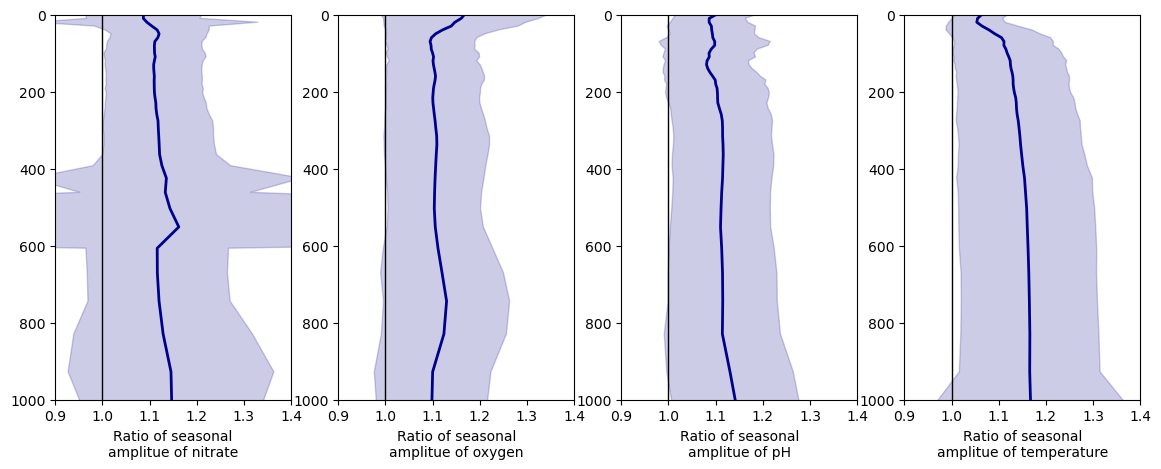

In [13]:
#----
# plot ratio vs depth
#----

color1 = 'darkblue'
color2 = 'black'
lw = 2
fs = 12
xlim1,xlim2 = 0,3.4

#---
# top XX m only
#---

depth_lim = 1000
xlim1,xlim2 = 0.9,1.4

fig, [ax1,ax2,ax3,ax4] = plt.subplots(1, 4, figsize=(14,5),gridspec_kw={'width_ratios': [1,1,1,1]})

ax1.vlines(1,0,depth_lim,color=color2,linewidth=1)
ax1.plot(no3_ampl_ratio_tropics,zlevs0[:-1],color=color1,linewidth=lw,zorder=2)
b1 = no3_ampl_ratio_tropics - no3_ampl_ratio_tropics_std
b2 = no3_ampl_ratio_tropics + no3_ampl_ratio_tropics_std
ax1.fill_betweenx(zlevs0[:-1],b1, b2, color=color1, alpha=0.2)
ax1.set_ylim((0,depth_lim))
ax1.invert_yaxis()
ax1.set_xlabel('Ratio of seasonal\namplitue of nitrate')
ax1.set_xlim((xlim1,xlim2))
#ax1.set_xticks(fontsize=fs)
#ax1.set_yticks(fontsize=fs)

ax2.vlines(1,0,depth_lim,color=color2,linewidth=1)
ax2.plot(oxy_ampl_ratio_tropics,zlevs0[:-1],color=color1,linewidth=lw)
b1 = oxy_ampl_ratio_tropics - oxy_ampl_ratio_tropics_std
b2 = oxy_ampl_ratio_tropics + oxy_ampl_ratio_tropics_std
ax2.fill_betweenx(zlevs0[:-1],b1, b2, color=color1, alpha=0.2)
ax2.set_ylim((0,depth_lim))
ax2.invert_yaxis()
ax2.set_xlabel('Ratio of seasonal\namplitue of oxygen')
ax2.set_xlim((xlim1,xlim2))
#ax2.set_xticks(fontsize=fs)
#ax2.set_yticks(fontsize=fs)

ax3.vlines(1,0,depth_lim,color=color2,linewidth=1)
ax3.plot(pH_ampl_ratio_tropics,zlevs0[:-1],color=color1,linewidth=lw)
b1 = pH_ampl_ratio_tropics - pH_ampl_ratio_tropics_std
b2 = pH_ampl_ratio_tropics + pH_ampl_ratio_tropics_std
ax3.fill_betweenx(zlevs0[:-1],b1, b2, color=color1, alpha=0.2)
ax3.set_ylim((0,depth_lim))
ax3.invert_yaxis()
ax3.set_xlabel('Ratio of seasonal\namplitue of pH')
ax3.set_xlim((xlim1,xlim2))
#ax3.set_xticks(fontsize=fs)
#ax3.set_yticks(fontsize=fs)

ax4.vlines(1,0,depth_lim,color=color2,linewidth=1)
ax4.plot(temp_ampl_ratio_tropics,zlevs0[:-1],color=color1,linewidth=lw)
b1 = temp_ampl_ratio_tropics - temp_ampl_ratio_tropics_std
b2 = temp_ampl_ratio_tropics + temp_ampl_ratio_tropics_std
ax4.fill_betweenx(zlevs0[:-1],b1, b2, color=color1, alpha=0.2)
ax4.set_ylim((0,depth_lim))
ax4.invert_yaxis()
ax4.set_xlabel('Ratio of seasonal\namplitue of temperature')
ax4.set_xlim((xlim1,xlim2))
#ax4.set_xticks(fontsize=fs)
#ax4.set_yticks(fontsize=fs)

plt.show()


#---
# why ist here no data below ~1800m????? 
# -> it had to do with floats that didn't experience any seasonal variability below that depth 
# -> these ended up as "inf" in the data set, causing NaNs in the regional avg
# -> it has been corrected in the calculation of the ratio
# (but I plan to only show the upper 1000m at max in the revised version of the case study, i.e., it does not matter!)
#---

# later: 
# add temperature to analysis
# include all years

# daily vs 10-daily



In [14]:
#--- 
# save as netcdf
#---
from netCDF4 import Dataset

save_netcdf = True
savepath    = '/global/cfs/cdirs/m4003/cnissen/floats/6year/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)
    
yy=0

# paths to files
path1 = '/global/cfs/cdirs/m4003/maltrud/6year/floats/'
file1 = 'floats.year'+year_list[yy]+'.nc'  
    
path2 = '/global/cfs/cdirs/m4003/cnissen/floats/6year/'
file2 = 'pH_floats_6year_'+year_list[yy]+'.nc'  

path3 = '/global/cfs/cdirs/m4003/maltrud/6year/monthlyEulerianAverages/'
file3 = 'monthlyAverageEulerianFields.year'+year_list[yy]+'.nc'
    
path4 = '/global/cfs/cdirs/m4003/cnissen/floats/6year/'
file4 = 'pH_monthlyAverageEulerianFields.year'+year_list[yy]+'.nc'
        
#np.zeros([len(ind1),len(zlevs)]) 
num_floats = no3_ampl_ratio.shape[1]

if save_netcdf: 
    netcdf_name = 'Seasonal_amplitude_year_'+str(year_list[yy])+'_daily_vs_10day_sampling.nc'
    #netcdf_name = 'List_grid_cells_with_float_obs_all_year_seasonal_amplitude_year'+str(year_list[yy])+'_min_days_per_month_'+str(min_num_in_month)+'_TROPICL_PACIFIC.nc'
    if not os.path.exists(savepath+netcdf_name):
        print('Create file '+savepath+netcdf_name)
        w_nc_fid = Dataset(savepath+netcdf_name, 'w', format='NETCDF4_CLASSIC')
        w_nc_fid.script = '/global/homes/c/cnissen/scripts/plot_floats_E3SM_Fig6_variability_NEW_daily_vs_10daily_floats_part1.ipynb'
        w_nc_fid.step1 = '1) compute seasonal amplitude along each float track'
        w_nc_fid.step2 = '2) 10-day sampling has randomly chosen start days (regular 10-day sampling starting from any of day 1-10)'
        w_nc_fid.step3 = '3) compute ratio of seasonal amplitude with daily vs. 10-day sampling'
        # create dimension & variable
        w_nc_fid.createDimension('depth', len(zlevs))  
        w_nc_fid.createDimension('num_floats', num_floats)  
        w_nc_fid.createDimension('time', no3_all_E3SM.shape[0])  
        w_nc_fid.createDimension('time_10', no3_all_E3SM_10.shape[0])  
        
        w_nc_var1 = w_nc_fid.createVariable('range_no3_daily', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on daily snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('range_no3_10day', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on 10-day snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('ratio_no3', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Ratio daily sampling / 10-day sampling'
        
        w_nc_var1 = w_nc_fid.createVariable('range_oxy_daily', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on daily snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('range_oxy_10day', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on 10-day snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('ratio_oxy', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Ratio daily sampling / 10-day sampling'
        
        w_nc_var1 = w_nc_fid.createVariable('range_pH_daily', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on daily snapshots from synthetic floats'
        w_nc_var1.data_source = path2+file2
        w_nc_var1 = w_nc_fid.createVariable('range_pH_10day', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on 10-day snapshots from synthetic floats'
        w_nc_var1.data_source = path2+file2
        w_nc_var1 = w_nc_fid.createVariable('ratio_pH', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Ratio daily sampling / 10-day sampling'

        w_nc_var1 = w_nc_fid.createVariable('range_temp_daily', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on daily snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('range_temp_10day', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Seasonal range (max minus min) based on 10-day snapshots from synthetic floats'
        w_nc_var1.data_source = path1+file1
        w_nc_var1 = w_nc_fid.createVariable('ratio_temp', 'f4',('num_floats','depth'))
        w_nc_var1.description = 'Ratio daily sampling / 10-day sampling'
        
        # daily path of all floats
        w_nc_var1 = w_nc_fid.createVariable('lat', 'f4',('num_floats','time'))
        w_nc_var1.description = 'Latitude in degN' 
        w_nc_var1.note        = 'Positions from daily sampling of each float trajectory' 
        w_nc_var1 = w_nc_fid.createVariable('lon', 'f4',('num_floats','time'))
        w_nc_var1.description = 'Longitude in degE'
        w_nc_var1.note        = 'Positions from daily sampling of each float trajectory' 
        
        # 10-day path of all floats (to facilitate later filtering for different regions)
        w_nc_var1 = w_nc_fid.createVariable('lat_10', 'f4',('num_floats','time_10'))
        w_nc_var1.description = 'Latitude in degN' 
        w_nc_var1.note        = 'Positions from 10-day sampling of each float trajectory' 
        w_nc_var1 = w_nc_fid.createVariable('lon_10', 'f4',('num_floats','time_10'))
        w_nc_var1.description = 'Longitude in degE'
        w_nc_var1.note        = 'Positions from 10-day sampling of each float trajectory' 
        
        # daily info: co-located biome, co-located model grid cell
        w_nc_var1 = w_nc_fid.createVariable('biome_daily', 'f4',('num_floats','time'))
        w_nc_var1.description = 'co-located biome' 
        w_nc_var1.data_source = path_biome+file_biome
        w_nc_var1 = w_nc_fid.createVariable('closest_node_daily', 'f4',('num_floats','time'))
        w_nc_var1.description = 'co-located closest model grid cell'
        w_nc_var1.data_source = path_biome+file_biome
        
        # 10-day info: co-located biome, co-located model grid cell
        w_nc_var1 = w_nc_fid.createVariable('biome_10day', 'f4',('num_floats','time_10'))
        w_nc_var1.description = 'co-located biome' 
        w_nc_var1.data_source = path_biome+file_biome
        w_nc_var1 = w_nc_fid.createVariable('closest_node_10day', 'f4',('num_floats','time_10'))
        w_nc_var1.description = 'co-located closest model grid cell'  
        w_nc_var1.data_source = path_biome+file_biome
    
        w_nc_var1 = w_nc_fid.createVariable('depth', 'f4',('depth'))
        w_nc_var1.description = 'Depth in m'
        #---
        # write lat/lon/depth into file
        #---
        w_nc_fid.variables['lat'][:,:]   = np.transpose(lat_all_E3SM) #lat_list
        w_nc_fid.variables['lon'][:,:]   = np.transpose(lon_all_E3SM) #lon_list
        w_nc_fid.variables['lat_10'][:,:]   = np.transpose(lat_all_E3SM_10) #lat_list
        w_nc_fid.variables['lon_10'][:,:]   = np.transpose(lon_all_E3SM_10) #lon_list
        w_nc_fid.variables['depth'][:] = zlevs
        w_nc_fid.close()
        
    #---
    # write fields to file
    w_nc_fid = Dataset(savepath+netcdf_name, 'r+', format='NETCDF4_CLASSIC') 
    # NO3
    w_nc_fid.variables['range_no3_daily'][:,:]   = np.transpose(no3_ampl_daily)
    w_nc_fid.variables['range_no3_10day'][:,:]   = np.transpose(no3_ampl_10day)
    w_nc_fid.variables['ratio_no3'][:,:]         = np.transpose(no3_ampl_ratio)
    # OXY
    w_nc_fid.variables['range_oxy_daily'][:,:]   = np.transpose(oxy_ampl_daily)
    w_nc_fid.variables['range_oxy_10day'][:,:]   = np.transpose(oxy_ampl_10day)
    w_nc_fid.variables['ratio_oxy'][:,:]         = np.transpose(oxy_ampl_ratio)
    # pH
    w_nc_fid.variables['range_pH_daily'][:,:]   = np.transpose(pH_ampl_daily)
    w_nc_fid.variables['range_pH_10day'][:,:]   = np.transpose(pH_ampl_10day)
    w_nc_fid.variables['ratio_pH'][:,:]         = np.transpose(pH_ampl_ratio)
    # temp
    w_nc_fid.variables['range_temp_daily'][:,:]   = np.transpose(temp_ampl_daily)
    w_nc_fid.variables['range_temp_10day'][:,:]   = np.transpose(temp_ampl_10day)
    w_nc_fid.variables['ratio_temp'][:,:]         = np.transpose(temp_ampl_ratio)
    # biome info
    w_nc_fid.variables['biome_daily'][:,:]      = np.transpose(biome_all)
    w_nc_fid.variables['biome_10day'][:,:]      = np.transpose(biome_all_10)
    # closest node
    w_nc_fid.variables['closest_node_daily'][:,:]  = np.transpose(closest_node_all)
    w_nc_fid.variables['closest_node_10day'][:,:]  = np.transpose(closest_node_all_10)
    #----
    w_nc_fid.close()  
    del netcdf_name
    
print('done')


Create file /global/cfs/cdirs/m4003/cnissen/floats/6year/Seasonal_amplitude_year_0057_daily_vs_10day_sampling.nc
done


In [15]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/floats/6year/


In [ ]:
#---
# plot a map and color the points as a function of the ratio: are there regional differences?
#---
# plot starting position of each float
# NOTE: the distribution of floats changes over the years!!! 

# get first non-NaN entry (depending on the randomly chosen start index, some floats might have a NaN on the first entry here...)
lat0=np.zeros(lat_all_E3SM_10.shape[1])
lon0=np.zeros(lon_all_E3SM_10.shape[1])
for ff in range(0,lat_all_E3SM_10.shape[1]):
    aux1 = lat_all_E3SM_10[:,ff]
    aux2 = lon_all_E3SM_10[:,ff]
    if ~np.isnan(aux1[0]):
        lat0[ff] = aux1[0]
        lon0[ff] = aux2[0]
    else:
        lat0[ff] = aux1[1]
        lon0[ff] = aux2[1]
    del aux1,aux2
    
#lat0 = lat_all_E3SM_10[0,:]
#lon0 = lon_all_E3SM_10[0,:]

dd = 0 # choose depth level to plot

ms = 0.8

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])

for nn in tqdm(range(0,lon0.shape[0])):
    #print(no3_ampl_ratio[dd,nn])
    plt.scatter(lon0[nn], lat0[nn],c=no3_ampl_ratio[dd,nn],s=ms,vmin=1,vmax=1.1,cmap=plt.cm.RdYlBu_r,marker='o',transform=ccrs.PlateCarree())
    #plt.plot(lon0[nn], lat0[nn],color='darkblue', marker='o',markersize=ms,transform=ccrs.Geodetic())
    
plt.colorbar(orientation='vertical')

ax.yaxis.tick_left()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
    
#save_plots = False
#if save_plots:
#    dpicnt = 200
#    if plot_first_day:
#        #filename = 'Map_test_run_initial_float_positions.png'
#        filename = 'Map_run_6years_initial_float_positions_only_deepOcean.png'
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()



In [ ]:

#w_nc_fid.mask_e3sm_all_regions = "1.NA SPSS, 2.NA STSS, 3.NA STPS, 4.AEQU, 5.SA STPS, 6.MED (not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "7.IND STPS, 8.(not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "9.NP SPSS, 10.NP STSS, 11.NP STPS, 12.PEQU-W, 13.PEQU-E, 14.SP STPS" ;
#w_nc_fid.mask_e3sm_all_regions = "15.ARCTIC ICE (not in FM14), 16.NP ICE, 17.NA ICE, 18.Barents (not in FM14)" ;
#w_nc_fid.mask_e3sm_all_regions = "19. STSS_Atl, 20. SPSS_Atl, 21. ICE_Atl, 22. STSS_Ind, 23. SPSS_Ind, 24. ICE_Ind, 25. STSS_Pac, 26. SPSS_Pac, 27. ICE_Pac"


#-----
# if there is a pattern in space: 
#
# for each large biome, get all floats that stay within that biome for a whole year
# get avg+std of the ratio of the seasonal amplitude (daily vs 10-day sampling)
#-----

# FOR NOW: only analyze tropical biomes -> where the model is eddy-permitting!

# instead of doing it based on biomes, only include those floats who stay within 21°S-21°N the whole year

print(closest_node_all_10.shape)
print(biome_all_10.shape)

# get first non-NaN entry (depending on the randomly chosen start index, some floats might have a NaN on the first entry here...)
biome_all_10_start=np.zeros(biome_all_10.shape[1])
for ff in range(0,biome_all_10.shape[1]):
    aux1 = biome_all_10[:,ff]
    if ~np.isnan(aux1[0]):
        biome_all_10_start[ff] = aux1[0]
    else:
        biome_all_10_start[ff] = aux1[1]
    del aux1
    
# check if float is in eddy-permitting region the whole year
is_in_tropics = np.zeros(lat_all_E3SM_10.shape[1])
for ff in range(0,lat_all_E3SM_10.shape[1]):
    aux1 = lat_all_E3SM_10[:,ff]
    ind=np.where(~np.isnan(aux1))[0]
    aux1 = aux1[ind]
    if all(i >=-21 for i in aux1): # if all latitudes are north of 21°S
        if all(i <=21 for i in aux1): # if all latitudes are south of 21°N
            is_in_tropics[ff]=1
    del aux1,ind

fig = plt.figure(figsize=(18,7)) # x, y
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-179, 179, -90, 90])

for nn in tqdm(range(0,lon0.shape[0])):
    #if biome_all_10_start[nn] in [4,5,7,8,11,12,13,14]: # only plot floats in certain biomes
    if is_in_tropics[nn]==1:
        plt.scatter(lon0[nn], lat0[nn],c=no3_ampl_ratio[dd,nn],s=ms,vmin=1,vmax=1.1,cmap=plt.cm.RdYlBu_r,marker='o',transform=ccrs.PlateCarree())
    #plt.plot(lon0[nn], lat0[nn],color='darkblue', marker='o',markersize=ms,transform=ccrs.Geodetic())
    
plt.colorbar(orientation='vertical')

ax.yaxis.tick_left()
ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
    
#save_plots = False
#if save_plots:
#    dpicnt = 200
#    if plot_first_day:
#        #filename = 'Map_test_run_initial_float_positions.png'
#        filename = 'Map_run_6years_initial_float_positions_only_deepOcean.png'
#    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')#,transparent=True)
    
plt.show()


In [ ]:
print(no3_ampl_ratio.shape[0])
print(no3_ampl_ratio[dd,:][ind_tropics])


In [ ]:
print(no3_ampl_ratio_tropics_std)
print(zlevs0)
print(pH_ampl_ratio_tropics)

In [ ]:

plot_starting_positions = False

if plot_starting_positions:
    fig = plt.figure(figsize=(18,7)) # x, y
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()
    ax.set_extent([-179, 179, -90, 90])

    for nn in tqdm(range(0,lon_all_E3SM.shape[1])):
        #print(no3_ampl_ratio[dd,nn])
        plt.plot(lon_all_E3SM[0,nn], lat_all_E3SM[0,nn],color='darkblue', marker='o',markersize=ms,transform=ccrs.Geodetic())

    ax.yaxis.tick_left()
    ax.set_xticks([-180,-120, -60, 0, 60, 120, 180],crs=ccrs.PlateCarree())
    ax.set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    plt.show()

